In [25]:
#TEST IMPORTS
import numpy as np
from ours.V3_3 import Ours_V3_3 
from ours.V1 import Ours_V1
from cscg.chmm_actions import CHMM, datagen_structured_obs_room

from envs.minigrid import GridWorldEnv
from visualisation_tools import *

In [2]:
rooms = np.array(
    [
        [0, 0, 1],
        [2, 0, 4],
        [3, 3, 3],
    ]
)

# rooms = np.array(
#     [
#         [0, 0, 1, 4],
#         [2, 0, 1, 3],
#         [3, 3, 3, 0],
#     ]
# ) #3x4 rooms, 1 ob per room

# rooms = np.array(
#     [
#         [0, 1],
#         [2, 3]
#     ]
# )

In [26]:
#ASSIGN COLORS TO ROOMS IDS

custom_colors = (
    np.array(
        [
            [255, 0, 0],
            [0, 255, 0],
            [50,50, 255],
            [112, 39, 195],
            [255, 255, 0],
            [100, 100, 100],
            [0, 0, 0],
            [255, 255, 255],
            
        ]
    )
    / 256
)

cmap = create_custom_cmap(custom_colors[:5])

In [4]:
actions = {'UP':2, 'RIGHT':1, 'DOWN':3, 'LEFT':0, 'STAY':4}
desired_state_mapping = {(i * rooms.shape[1] + j): (i, j) for i in range(rooms.shape[0]) for j in range(rooms.shape[1])}

In [5]:
#TEST MODELS INIT
minigrid_env = GridWorldEnv(rooms, actions)
start_pose = (0,0)
ob = minigrid_env.reset(start_pose)
start_state_idx = minigrid_env.get_state(start_pose)


ours_v3_3 = Ours_V3_3(num_obs=2, num_states=2, observations=[ob,start_pose], learning_rate_pB=3.0, actions= actions)
ours_v1 = Ours_V1(num_obs=2, num_states=2, observations=[ob,start_state_idx], learning_rate_pB=3.0, actions= actions)


In [6]:
#INIT SETUP VISUALISATION
plot_observations_and_states(minigrid_env,start_pose)

position in rooms observations
[['x' 0 -1]
 [-1 0 -1]
 [-1 -1 -1]]
rooms ideal generated states
[[0 0 -1]
 [-1 0 -1]
 [-1 -1 -1]]


In [7]:
#RUN

action_hist = []
T= 10
pose = start_pose
for t in range(0,T):
    print(' __ ')
    print('time', t, 'believed Qs:',ours_v3_3.get_current_belief()[0].round(3))
    action = ours_v3_3.infer_action()
    action_hist.append(action)
    ob, pose = minigrid_env.step(action, pose)

    next_possible_actions = minigrid_env.get_next_possible_motions(pose)
    print('action taken:',int(action),'pose:',pose,',ob:', ob)
    ours_v3_3.agent_step_update(action,[ob,pose],next_possible_actions)

 __ 
time 0 believed Qs: [1. 0.]


action taken: 4 pose: (0, 0) ,ob: 0
prior on believed state [0.8 0.2]
update_B: a 4 qs[factor] [0.8 0.2] qs_prev[factor] [1. 0.]
after updates believed Qs: [0.932 0.068]
update_B: a 2 qs[factor] [0.932 0.068] qs_prev[factor] [0.932 0.068]
a 1 n pose (0, 1) 1
update_B: a 1 qs[factor] [0. 1.] qs_prev[factor] [0.932 0.068]
a 3 n pose (1, 0) 2
update_B: a 3 qs[factor] [0.636 0.188 0.176] qs_prev[factor] [0.932 0.068 0.   ]
update_B: a 0 qs[factor] [0.932 0.068 0.   ] qs_prev[factor] [0.932 0.068 0.   ]
update_B: a 4 qs[factor] [0.932 0.068 0.   ] qs_prev[factor] [0.932 0.068 0.   ]
 __ 
time 1 believed Qs: [0.932 0.068 0.   ]
action taken: 1 pose: (0, 1) ,ob: 0
prior on believed state [0. 1. 0.]
update_B: a 1 qs[factor] [0. 1. 0.] qs_prev[factor] [0.932 0.068 0.   ]
update_B: a 0 qs[factor] [0.932 0.068 0.   ] qs_prev[factor] [0. 1. 0.]
after updates believed Qs: [0. 1. 0.]
update_B: a 2 qs[factor] [0. 1. 0.] qs_prev[factor] [0. 1. 0.]
a 1 n pose (0, 2) 3
update_B: a 1 qs[factor] [0.217 0.

In [8]:
plot_observations_and_states(minigrid_env,start_pose)

position in rooms observations
[['x' 0 -1]
 [1 0 3]
 [2 2 2]]
rooms ideal generated states
[[0 1 -1]
 [3 2 6]
 [4 5 2]]


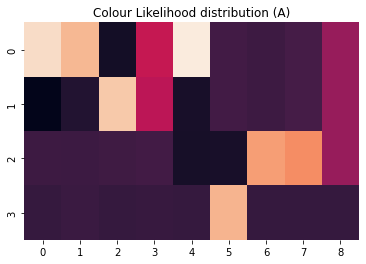

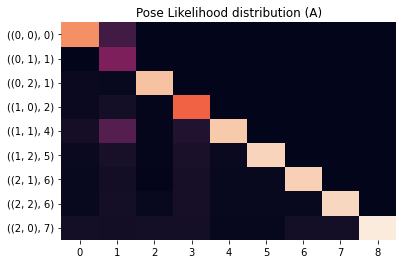

In [10]:
plot_likelihood(ours_v3_3.agent.A[0], tittle_add='Colour')
plot_likelihood(ours_v3_3.agent.A[1], ours_v3_3.agent_state_mapping, tittle_add='Pose')

In [ ]:
plot_path_in_map(minigrid_env, start_pose, action_hist[:54])

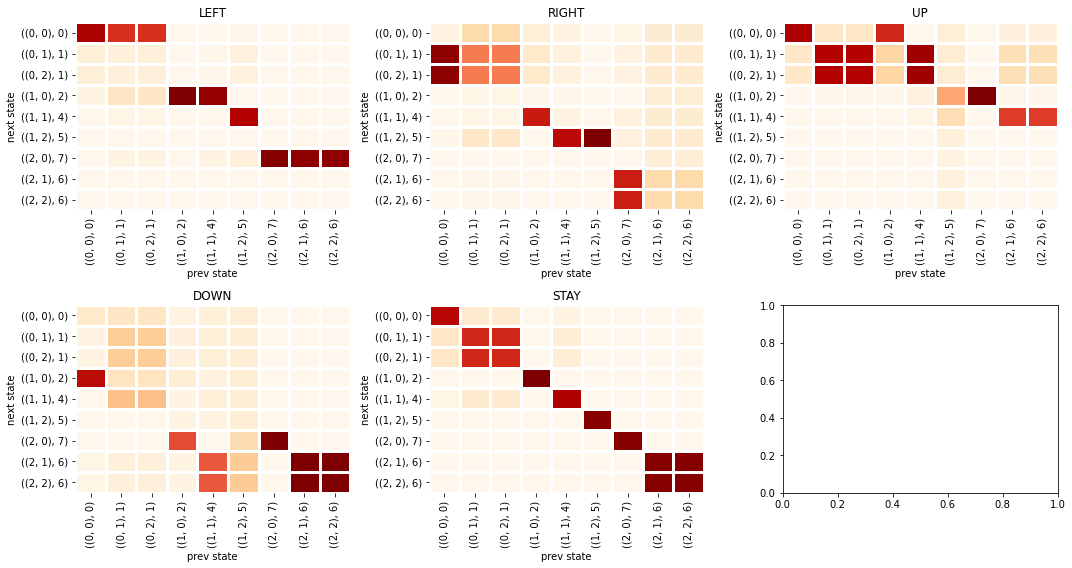

In [11]:
plot_transition_detailed(ours_v3_3.agent.B[0], actions, ours_v3_3.agent_state_mapping, desired_state_mapping)

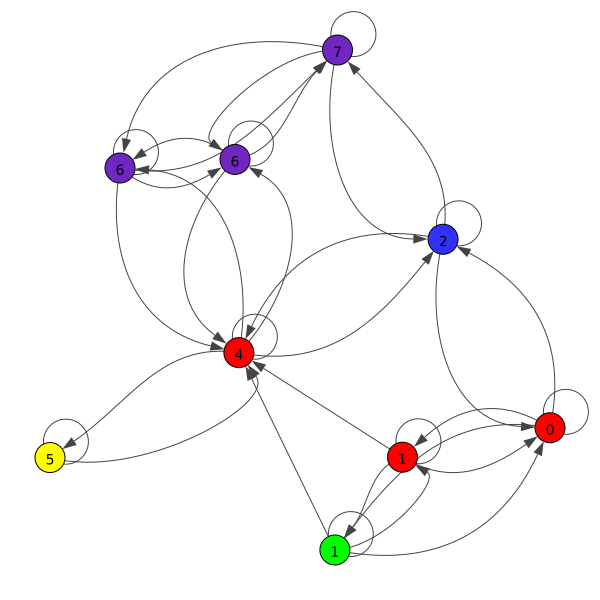

In [23]:
state_mapping = set_observation_as_rooms_idx(ours_v3_3.agent_state_mapping, rooms)
# obs = [value['ob'] for key, value in agent_state_mapping.items()]

graph = plot_graph_as_cscg(ours_v3_3.agent.B, state_mapping, cmap, edge_threshold=0.1)
graph